In [1]:
import json
import urllib.request
import pandas as pd

In [2]:
pangos = [
    "XE",
    "XB",
    "XBB",
    "XBF",
    "XN",
    "XAS",
    "XBE",
    "XL",
    "XJ",
    "XQ",
    "XP",
    "XZ",
    "XBG",
    "XBK",
    "XBD",
    "XW",
    "XA",
    "XM",
    "XAJ",
    "XY",
    "XAM",
    "XS",
    "XF",
    "XBQ",
    "XR",
    "XAP",
    "XAA",
    "XAF",
    "XBM",
    "XAV",
    "XAU",
    "XAE",
    "XAN",
    "XAG",
    "XBH",
    "XC",
    "XBR",
    "XH",
    "XAD",
    "XG",
    "XAL",
    "XU",
    "XAB",
    "XAH",
    "XAQ",
    "XAR",
    "XAT",
    "XBJ",
    "XK",
    "XT",
    "XV",
]
len(pangos)

51

In [3]:
# https://github.com/jeromekelleher/sc2ts-paper/issues/325#issuecomment-2659019906
skip_pangos = [
    "XAB",  # Failed sc2ts missing site QC
    "XAH",  # Failed sc2ts missing site QC
    "XAQ",  # Not in Viridian v04
    "XAR",  # Not in Viridian v04
    "XAT",  # Not in Viridian v04
    "XBJ",  # SKIP FOR NOW but see comment
    "XK",   # Not in Viridian v04
    "XT",   # Not in Viridian v04
    "XV",   # Not in Viridian v04
    "XBQ",  # https://github.com/jeromekelleher/sc2ts-paper/issues/195#issuecomment-2665567347
    "XBR", # https://github.com/jeromekelleher/sc2ts-paper/issues/195#issuecomment-2665567347
]
len(skip_pangos)

11

In [4]:
alias_key_url = "https://raw.githubusercontent.com/cov-lineages/pango-designation/refs/heads/master/pango_designation/alias_key.json"
with urllib.request.urlopen(alias_key_url) as url:
    alias_key = json.load(url)

In [5]:
num_total_x = 0
num_one_bkpt = 0
num_multiple_bkpts = 0
for x in alias_key:
    if x.startswith("X"):
        num_total_x += 1
        if len(alias_key[x]) == 2:
            num_one_bkpt += 1
        else:
            num_multiple_bkpts += 1
print(f"Pango X: {num_total_x}")
print(f"One breakpoint: {num_one_bkpt}")
print(f"More breakpoints: {num_multiple_bkpts}")

Pango X: 144
One breakpoint: 123
More breakpoints: 21


#### Concordance of Pango identity of parents

In [6]:
def is_concordant(*, ground_truth, query):
    def _remap(x):
        if x.endswith("*"):
            x = x[:-1]
        split = x.split(".")
        alias = alias_key.get(split[0], "")
        if alias != "":
            x = ".".join([alias] + split[1:])
        return x
    pango_gt = _remap(ground_truth)
    pango_cp = _remap(query)
    if (pango_cp == pango_gt) or (pango_cp.startswith(pango_gt + ".")):
        return True
    else:
        return False

In [7]:
def compare_pango_parents(df, comparator):
    df_gt = df[df["method"] == "groundtruth"]
    df_cp = df[df["method"] == comparator]

    list_concordant = []
    list_discrepant = []
    list_nonrecomb = []

    for p in pangos:
        if p in skip_pangos:
            continue

        tmp_df_gt = df_gt[df_gt["pango"] == p]
        tmp_df_cp = df_cp[df_cp["pango"] == p]

        left_pango_parent_gt = tmp_df_gt.iloc[0]["left_pango_parent"]
        left_pango_parent_cp = tmp_df_cp.iloc[0]["left_pango_parent"]
        right_pango_parent_gt = tmp_df_gt.iloc[0]["right_pango_parent"]
        right_pango_parent_cp = tmp_df_cp.iloc[0]["right_pango_parent"]

        if left_pango_parent_cp == "na" or right_pango_parent_cp == "na":
            list_nonrecomb.append(p)
            continue

        is_left_concordant = is_concordant(
            ground_truth=left_pango_parent_gt,
            query=left_pango_parent_cp,
        )
        is_right_concordant = is_concordant(
            ground_truth=right_pango_parent_gt,
            query=right_pango_parent_cp,
        )
        if is_left_concordant and is_right_concordant:
            list_concordant.append(p)
        else:
            list_discrepant.append(p)
            print(
                p,
                "left", [left_pango_parent_gt, left_pango_parent_cp],
                "right", [right_pango_parent_gt, right_pango_parent_cp],
            )

    return (list_concordant, list_discrepant, list_nonrecomb)

In [8]:
methods_df = pd.read_csv("../data/methods_comparison.csv")

print(f"Discrepant recombinants: GT vs sc2ts")
(
    concordant_sc2ts, discrepant_sc2ts, nonrecomb_sc2ts
) = compare_pango_parents(
    df=methods_df,
    comparator="sc2ts",
)
print("\n")

print(f"Discrepant recombinants: GT vs RH-GISAID")
(
    concordant_rh, discrepant_rh, nonrecomb_rh
) = compare_pango_parents(
    df=methods_df,
    comparator="recombinhunt_gisaid",
)
print("\n")

print(f"Concordant recombinants")
print(f"GT vs sc2ts: {len(concordant_sc2ts)}")
print(f"GT vs RH-GISAID: {len(concordant_rh)}")
print("\n")

print(f"Non-recombinants")
print(f"GT vs sc2ts: {len(nonrecomb_sc2ts)}")
print(f"GT vs RH-GISAID: {len(nonrecomb_rh)}")

Discrepant recombinants: GT vs sc2ts
XBB left ['BJ.1', 'BA.2.10'] right ['BM.1.1.1', 'BM.1.1.1']
XBF left ['BA.5.2', 'BA.5.2.1'] right ['CJ.1', 'BM.1.1.1']
XBH left ['BA.2.3.17', 'BA.2.1'] right ['BA.2.75.2', 'BA.2.75.2']


Discrepant recombinants: GT vs RH-GISAID
XAS left ['BA.5*', 'BA.4.8'] right ['BA.2*', 'BA.2.65']
XBE left ['BA.5.2*', 'BA.5.2.6'] right ['BE.4.1', 'BE.4']
XBM left ['BA.2.76', 'BF.3'] right ['BF.3', 'BA.2.76;BF.3']
XBH left ['BA.2.3.17', 'BA.2.75.2'] right ['BA.2.75.2', 'BA.2.3.17;BA.2.75.2']


Concordant recombinants
GT vs sc2ts: 26
GT vs RH-GISAID: 30


Non-recombinants
GT vs sc2ts: 11
GT vs RH-GISAID: 6


#### Overlap of breakpoint intervals

In [9]:
def overlap_breakpoint_intervals(ground_truth, comparator):
    assert ground_truth[0] < ground_truth[1]
    assert comparator[0] < comparator[1]
    gt_size = ground_truth[1] - ground_truth[0]
    cp_size = comparator[1] - comparator[0]
    def _get_overlap(a, b):
        return max(0, min(a[1], b[1]) - max(a[0], b[0]))
    overlap_size = _get_overlap(a=ground_truth, b=comparator)
    is_overlap_with_gt = overlap_size > 0
    overlap_gt_size_ratio = overlap_size / gt_size
    cp_gt_size_ratio = cp_size / gt_size
    return (is_overlap_with_gt, overlap_gt_size_ratio, cp_gt_size_ratio)


def compare_breakpoint_intervals(df, comparator):
    df_gt = df[df["method"] == "groundtruth"]
    df_cp = df[df["method"] == comparator]

    num_recombs = 0
    num_overlap = 0

    res_df = pd.DataFrame(
        columns=[
            "pango",
            "is_overlap_with_gt",
            "overlap_gt_size_ratio",
            "cp_gt_size_ratio",
            "left_bkpt_gt",
            "right_bkpt_gt",
            "left_bkpt_cp",
            "right_bkpt_cp",
        ]
    )
    i = 0
    for p in pangos:
        if p in skip_pangos:
            continue

        tmp_df_gt = df_gt[df_gt["pango"] == p]
        tmp_df_cp = df_cp[df_cp["pango"] == p]

        bkpts_gt = [
            tmp_df_gt.iloc[0]["left_breakpoint"],
            tmp_df_gt.iloc[0]["right_breakpoint"],
        ]
        bkpts_cp = [
            tmp_df_cp.iloc[0]["left_breakpoint"],
            tmp_df_cp.iloc[0]["right_breakpoint"],
        ]

        if (bkpts_gt[1] in ["na", "-"]) or \
            (bkpts_cp[1] in ["na", "-"]):
            continue

        bkpts_gt[0] = int(bkpts_gt[0])
        bkpts_gt[1] = int(bkpts_gt[1])
        bkpts_cp[0] = int(bkpts_cp[0])
        bkpts_cp[1] = int(bkpts_cp[1])

        num_recombs += 1

        (
            is_overlap_with_gt,
            overlap_gt_size_ratio,
            cp_gt_size_ratio,
        ) = overlap_breakpoint_intervals(
            ground_truth=bkpts_gt,
            comparator=bkpts_cp,
        )

        if is_overlap_with_gt:
            num_overlap += 1

        res_df.loc[i] = [
            p,
            is_overlap_with_gt,
            overlap_gt_size_ratio,
            cp_gt_size_ratio,
            bkpts_gt[0],
            bkpts_gt[1],
            bkpts_cp[0],
            bkpts_cp[1],
        ]
        i += 1

    print(f"Total: {num_recombs}")
    print(f"Overlap: {num_overlap}")

    return res_df

In [10]:
sc2ts_bkpt_df = compare_breakpoint_intervals(
    df=methods_df,
    comparator="sc2ts",
)
sc2ts_bkpt_df

Total: 29
Overlap: 19


,pango,is_overlap_with_gt,overlap_gt_size_ratio,cp_gt_size_ratio,left_bkpt_gt,right_bkpt_gt,left_bkpt_cp,right_bkpt_cp
0,XE,True,0.998811,1.294887,10447,11288,10448,11537
1,XBB,False,0.000000,5.568182,22891,22935,22332,22577
2,XBF,True,0.666667,1560.666667,9864,9867,5184,9866
3,XL,True,1.000000,1.315565,6517,8393,5925,8393
4,XJ,True,1.000000,1.002856,13199,17401,13196,17410
5,XQ,True,0.999061,0.999061,4321,5386,4322,5386
6,XZ,False,0.000000,8.189474,26061,26251,24504,26060
7,XBG,True,1.000000,1.936709,22600,22916,22305,22917
8,XBD,True,0.995012,0.997506,23012,24616,23020,24620
9,XW,True,1.000000,1.101406,2833,4184,2833,4321


In [11]:
rh_bkpt_df = compare_breakpoint_intervals(
    df=methods_df,
    comparator="recombinhunt_gisaid",
)
rh_bkpt_df

Total: 31
Overlap: 19


,pango,is_overlap_with_gt,overlap_gt_size_ratio,cp_gt_size_ratio,left_bkpt_gt,right_bkpt_gt,left_bkpt_cp,right_bkpt_cp
0,XE,True,0.001189,0.001189,10447,11288,10447,10448
1,XBB,True,0.022727,0.022727,22891,22935,22897,22898
2,XAS,False,0.000000,0.000211,23039,27788,27811,27812
3,XBE,False,0.000000,0.000982,22591,23609,26719,26720
4,XL,False,0.000000,0.000533,6517,8393,6512,6513
5,XJ,False,0.000000,0.000238,13199,17401,13196,13197
6,XQ,True,0.000939,0.000939,4321,5386,4330,4331
7,XZ,False,0.000000,0.005263,26061,26251,26274,26275
8,XBG,True,0.003165,0.003165,22600,22916,22891,22892
9,XBD,True,0.000623,0.000623,23012,24616,24494,24495


In [14]:
import matplotlib.pyplot as plt

def plot_breakpoint_interval_properties(df, title):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 2))
    fig.suptitle(title)
    ax[0].set_ylabel("Number of recombinants")
    ax[0].set_xlabel("Interval overlap size / truth interval size")
    ax[0].hist(df["overlap_gt_size_ratio"], bins=30)
    ax[1].set_xlabel("Comparator interval size / truth interval size")
    ax[1].hist(df["cp_gt_size_ratio"], bins=30);

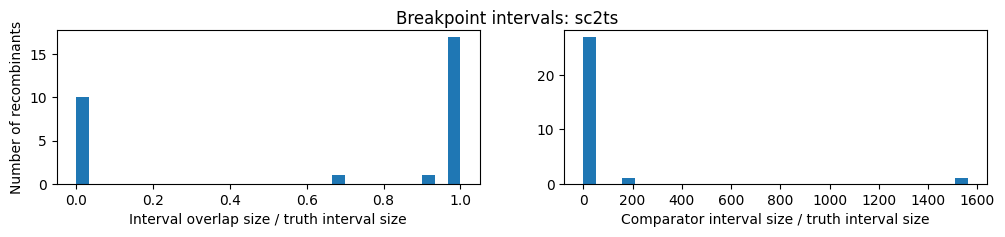

In [15]:
plot_breakpoint_interval_properties(sc2ts_bkpt_df, title="Breakpoint intervals: sc2ts")

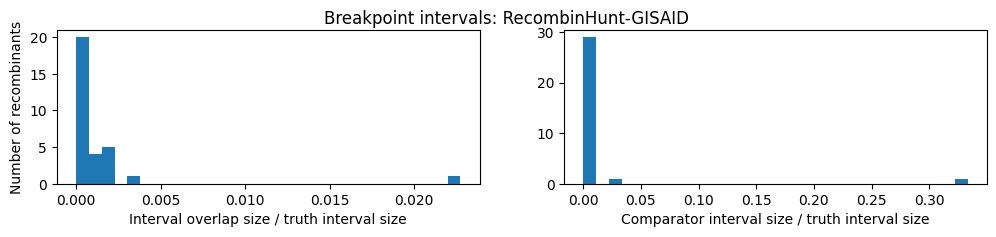

In [16]:
# Not really useful, since the breakpoint intervals are misleadingly precise.
plot_breakpoint_interval_properties(rh_bkpt_df, title="Breakpoint intervals: RecombinHunt-GISAID")